In [841]:
import numpy as np 
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy.fft import fft, fftfreq

In [842]:
data =pd.read_csv("SBER_240101_240430.csv", delimiter=";")

In [843]:
data.head() 

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>
0,SBER,D,240103,0,274.56
1,SBER,D,240104,0,274.12
2,SBER,D,240105,0,273.62
3,SBER,D,240108,0,276.76
4,SBER,D,240109,0,275.28


In [844]:
data.drop(columns=['<PER>','<TIME>','<TICKER>','<DATE>'],inplace=True)

In [845]:
data.head()

,<CLOSE>
0,274.56
1,274.12
2,273.62
3,276.76
4,275.28


Text(0.5, 1.0, 'График цен закрытия SBER за указанный промежуток')

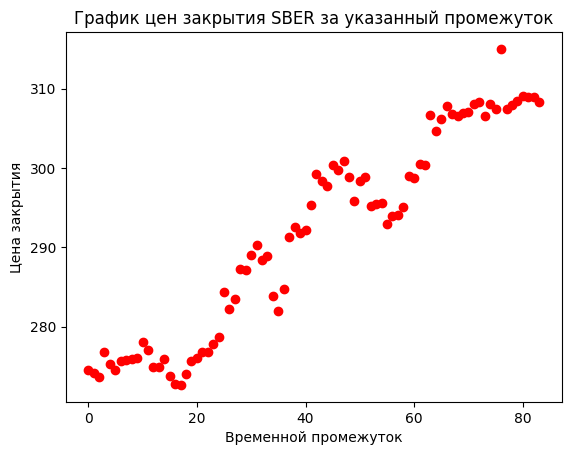

In [846]:
plot = plt.plot([i for i in range(len(data))], data["<CLOSE>"].to_numpy(), 'ro')
plt.xlabel("Временной промежуток")
plt.ylabel("Цена закрытия")
plt.title("График цен закрытия SBER за указанный промежуток")

In [847]:
#Линейная регрессия
time = np.array([i for i in range(len(data))])
X = np.array([i for i in range(len(data))]).reshape(-1,1)
y = data['<CLOSE>']

In [848]:
import statsmodels.api as sm

# Добавляем константу для учета свободного члена
X_with_const = sm.add_constant(X)

# Строим модель
sm_model = sm.OLS(y, X_with_const).fit()

# Выводим результаты
print(sm_model.summary())


                            OLS Regression Results                            
Dep. Variable:                <CLOSE>   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     990.8
Date:                Sat, 28 Dec 2024   Prob (F-statistic):           1.50e-47
Time:                        17:51:42   Log-Likelihood:                -224.50
No. Observations:                  84   AIC:                             453.0
Df Residuals:                      82   BIC:                             457.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        270.7838      0.767    353.097      0.0

In [849]:
#Таким образом коэффициент x1 - статистически значим и в данном случае существует выраженная линия тренда, которую так же видно и на графике, А вообще говоря значения R^2 говорят об очень хорошем приближении данных этой моделью

In [850]:
model_params = np.array(sm_model.params)

Text(0.5, 1.0, 'Цены закрытия с линейным трендом')

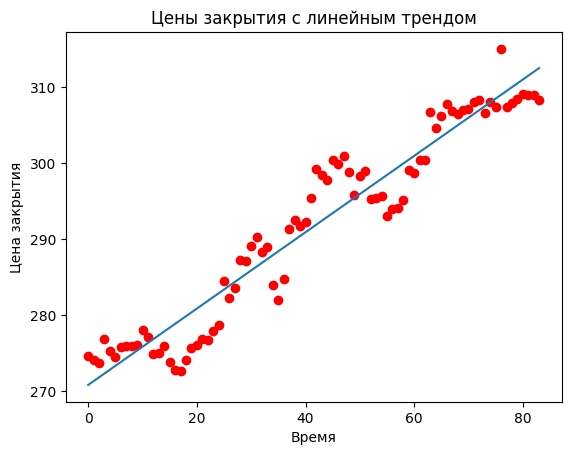

In [851]:
plt.plot([i for i in range(len(data))], data["<CLOSE>"].to_numpy(), 'ro',[i for i in range(len(data))] ,[(i*model_params[1]+model_params[0]) for i in range(len(data))])
plt.xlabel("Время")
plt.ylabel("Цена закрытия")
plt.title("Цены закрытия с линейным трендом")

Text(0.5, 1.0, 'График остатков для разложения')

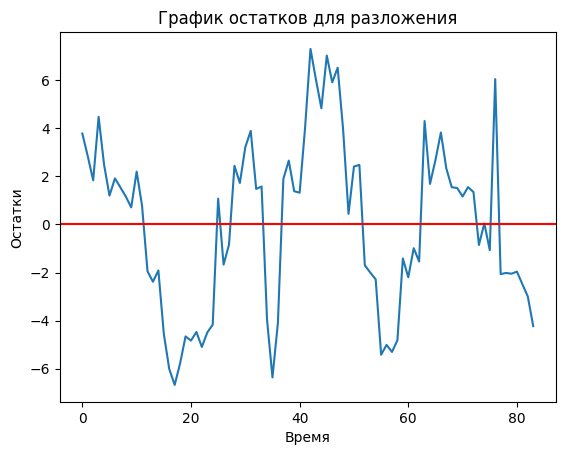

In [852]:
plt.plot(time,y.to_numpy()-[(i*model_params[1]+model_params[0]) for i in range(len(data))])
plt.axhline(0, color ='red')
plt.xlabel("Время")
plt.ylabel("Остатки")
plt.title("График остатков для разложения")

In [853]:
residuals = y.to_numpy()-[(i*model_params[1]+model_params[0]) for i in range(len(data))]

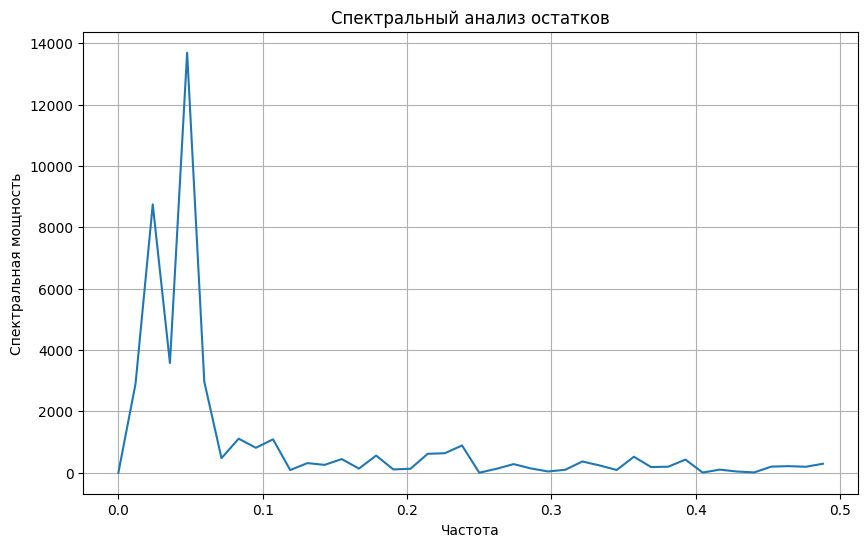

In [854]:
# Количество точек данных
N = len(residuals)

# Дискретное преобразование Фурье
frequencies = fftfreq(N)  # Частоты
amplitudes = fft(residuals)  # Преобразование

# Спектральная мощность
power = np.abs(amplitudes)**2

# Отображаем положительные частоты
positive_frequencies = frequencies[:N // 2]
positive_power = power[:N // 2]

# Построение спектра
plt.figure(figsize=(10, 6))
plt.plot(positive_frequencies, positive_power)
plt.title("Спектральный анализ остатков")
plt.xlabel("Частота")
plt.ylabel("Спектральная мощность")
plt.grid()
plt.show()


In [855]:
#Исходя из графика спектральной мощности для частот видим 3 значимых амплитуды - найдём соответствующие частоты. 

In [856]:
top_indices = np.argsort(positive_power)[-3:]
top_frequencies = positive_frequencies[top_indices]

In [857]:
print(top_frequencies)

[0.03571429 0.02380952 0.04761905]


In [858]:
#Тогда наибольшей амлпитуде будет соответствовать частота 0.047619

In [859]:
max(top_frequencies)

0.047619047619047616

In [860]:
# Находим частоту с максимальной мощностью
max_freq = max(top_frequencies)
top_frequencies = np.delete(top_frequencies,np.argmax(top_frequencies))

# Добавляем признаки косинуса и синуса для максимальной частоты
cos_component = np.cos(2 * np.pi * max_freq * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_freq * time).reshape(-1, 1)

# Формируем новую матрицу признаков для остатков
X_residuals = np.hstack([cos_component, sin_component])

# Строим модель регрессии для остатков (без добавления свободного члена)
model_residuals = sm.OLS(residuals, X_residuals).fit()

# Выводим результаты
print(model_residuals.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.316
Model:                            OLS   Adj. R-squared (uncentered):              0.299
Method:                 Least Squares   F-statistic:                              18.95
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                    1.71e-07
Time:                        17:51:42   Log-Likelihood:                         -208.54
No. Observations:                  84   AIC:                                      421.1
Df Residuals:                      82   BIC:                                      425.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [861]:
#Здесь значение коэффициента c1 (при cos(\omega_1)) уже не является статистически значимым - тогда оставим только синус d1, который является статистимчески значимым, 
#При этом модель получилась статистически значимой.

In [862]:
#Построим модель только для синуса

In [863]:
# Добавляем только компонент косинуса для максимальной частоты
sin_component = np.sin(2 * np.pi * max_freq * time).reshape(-1, 1)

# Строим модель регрессии для обновленных остатков (только с синусом)
model_residuals_updated = sm.OLS(residuals, sin_component).fit()
pred_model_1 = model_residuals_updated.predict(sin_component)

# Выводим результаты новой модели
print(model_residuals_updated.summary())
residuals = residuals - pred_model_1

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.314
Model:                            OLS   Adj. R-squared (uncentered):              0.306
Method:                 Least Squares   F-statistic:                              38.02
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                    2.42e-08
Time:                        17:51:42   Log-Likelihood:                         -208.66
No. Observations:                  84   AIC:                                      419.3
Df Residuals:                      83   BIC:                                      421.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [864]:
#Полученная модель является стаистически значимой, ровно как и коэффициент d1

In [865]:
top_frequencies

array([0.03571429, 0.02380952])

In [866]:
#Вторая частота с наибольшим откликом: 
max_freq = top_frequencies[1]
top_frequencies = np.delete(top_frequencies,[1])


In [867]:
top_frequencies

array([0.03571429])

In [868]:
# Добавляем признаки косинуса и синуса для максимальной частоты
cos_component = np.cos(2 * np.pi * max_freq * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_freq * time).reshape(-1, 1)

# Формируем новую матрицу признаков для остатков
X_residuals = np.hstack([cos_component, sin_component])

# Строим модель регрессии для остатков (без добавления свободного члена)
model_residuals = sm.OLS(residuals, X_residuals).fit()

# Выводим результаты
print(model_residuals.summary())
predictions = model_residuals.predict(X_residuals)
residuals -= predictions

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.295
Model:                            OLS   Adj. R-squared (uncentered):              0.277
Method:                 Least Squares   F-statistic:                              17.12
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                    6.13e-07
Time:                        17:51:42   Log-Likelihood:                         -194.01
No. Observations:                  84   AIC:                                      392.0
Df Residuals:                      82   BIC:                                      396.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [869]:
#Эта модель, ровно как и коэффициенты c2,d2 являются статистически значимыми, продолжим вычисления

In [870]:
#Продолжим. Третья частота
max_freq = max(top_frequencies)
top_frequencies = np.delete(top_frequencies,[0])

In [871]:
max_freq

0.03571428571428571

In [872]:
# Добавляем признаки косинуса и синуса для максимальной частоты
cos_component = np.cos(2 * np.pi * max_freq * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_freq * time).reshape(-1, 1)

# Формируем новую матрицу признаков для остатков
X_residuals = np.hstack([cos_component, sin_component])

# Строим модель регрессии для остатков (без добавления свободного члена)
model_residuals = sm.OLS(residuals, X_residuals).fit()

# Выводим результаты
print(model_residuals.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.171
Model:                            OLS   Adj. R-squared (uncentered):              0.150
Method:                 Least Squares   F-statistic:                              8.436
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                    0.000466
Time:                        17:51:42   Log-Likelihood:                         -186.15
No. Observations:                  84   AIC:                                      376.3
Df Residuals:                      82   BIC:                                      381.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [873]:
#Коэффициенты с3, d3, модели 

In [874]:
#Найдем 4 наиболее коррелирующую частоту
top_4index = np.argsort(positive_power)[-4]
max_freq = positive_frequencies[top_4index]

In [875]:
max_freq

0.05952380952380952

In [876]:
# Добавляем признаки косинуса и синуса для максимальной частоты
cos_component = np.cos(2 * np.pi * max_freq * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_freq * time).reshape(-1, 1)

# Формируем новую матрицу признаков для остатков
X_residuals = np.hstack([cos_component, sin_component])

# Строим модель регрессии для остатков (без добавления свободного члена)
model_residuals = sm.OLS(residuals, X_residuals).fit()

# Выводим результаты
print(model_residuals.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.142
Model:                            OLS   Adj. R-squared (uncentered):              0.121
Method:                 Least Squares   F-statistic:                              6.760
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                     0.00192
Time:                        17:51:42   Log-Likelihood:                         -187.60
No. Observations:                  84   AIC:                                      379.2
Df Residuals:                      82   BIC:                                      384.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [877]:
#Коэффициенты с4, d4 всё так же значимы, как и модель

In [878]:
#Найдем 5 наиболее коррелирующую частоту
top_5index = np.argsort(positive_power)[-5]
max_freq = positive_frequencies[top_5index]

In [879]:
max_freq

0.011904761904761904

In [880]:
# Добавляем признаки косинуса и синуса для максимальной частоты
cos_component = np.cos(2 * np.pi * max_freq * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_freq * time).reshape(-1, 1)

# Формируем новую матрицу признаков для остатков
X_residuals = np.hstack([cos_component, sin_component])

# Строим модель регрессии для остатков (без добавления свободного члена)
model_residuals = sm.OLS(residuals, X_residuals).fit()

# Выводим результаты
print(model_residuals.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.139
Model:                            OLS   Adj. R-squared (uncentered):              0.118
Method:                 Least Squares   F-statistic:                              6.599
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                     0.00220
Time:                        17:51:42   Log-Likelihood:                         -187.74
No. Observations:                  84   AIC:                                      379.5
Df Residuals:                      82   BIC:                                      384.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [881]:
#c5,d5 , модель значима

In [882]:
#Найдем 6 наиболее коррелирующую частоту
top_5index = np.argsort(positive_power)[-6]
max_freq = positive_frequencies[top_5index]

In [883]:
max_freq

0.08333333333333333

In [884]:
# Добавляем признаки косинуса и синуса для максимальной частоты
cos_component = np.cos(2 * np.pi * max_freq * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_freq * time).reshape(-1, 1)

# Формируем новую матрицу признаков для остатков
X_residuals = np.hstack([cos_component, sin_component])

# Строим модель регрессии для остатков (без добавления свободного члена)
model_residuals = sm.OLS(residuals, X_residuals).fit()

# Выводим результаты
print(model_residuals.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.053
Model:                            OLS   Adj. R-squared (uncentered):              0.030
Method:                 Least Squares   F-statistic:                              2.293
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                       0.107
Time:                        17:51:42   Log-Likelihood:                         -191.72
No. Observations:                  84   AIC:                                      387.4
Df Residuals:                      82   BIC:                                      392.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [885]:
#Коэффициенты c6,d6 статистически значимы, как и модель

In [886]:
#Найдем 7 наиболее коррелирующую частоту
top_5index = np.argsort(positive_power)[-7]
max_freq = positive_frequencies[top_5index]

In [887]:
max_freq

0.10714285714285714

In [888]:
# Добавляем признаки косинуса и синуса для максимальной частоты
cos_component = np.cos(2 * np.pi * max_freq * time).reshape(-1, 1)
sin_component = np.sin(2 * np.pi * max_freq * time).reshape(-1, 1)

# Формируем новую матрицу признаков для остатков
X_residuals = np.hstack([cos_component, sin_component])

# Строим модель регрессии для остатков (без добавления свободного члена)
model_residuals = sm.OLS(residuals, X_residuals).fit()

# Выводим результаты
print(model_residuals.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.052
Model:                            OLS   Adj. R-squared (uncentered):              0.029
Method:                 Least Squares   F-statistic:                              2.245
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                       0.112
Time:                        17:51:42   Log-Likelihood:                         -191.77
No. Observations:                  84   AIC:                                      387.5
Df Residuals:                      82   BIC:                                      392.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [889]:
#Коэффициент при косинусе не является значимым - не включаем в модель, включаем d7

In [890]:
#Найдем 8 наиболее коррелирующую частоту
top_5index = np.argsort(positive_power)[-8]
max_freq = positive_frequencies[top_5index]